<a href="https://colab.research.google.com/github/NehaTadavi/FODIP-Lab-Assignments/blob/main/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift


In [2]:
path = kagglehub.dataset_download("bulentsiyah/opencv-samples-images")
print("Dataset path:", path)

100%|██████████| 13.3M/13.3M [00:00<00:00, 15.0MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/bulentsiyah/opencv-samples-images/versions/14


In [3]:
image_files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
print("Found", len(image_files), "images")

Found 11 images


In [4]:
def load_image_gray(fname, size=256):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32)/255.0

images = [load_image_gray(f) for f in image_files[:5]]  # take first 5 for demo


In [5]:
def motion_blur_psf(length, angle_deg, size):
    psf = np.zeros((size,size))
    angle = np.deg2rad(angle_deg)
    cx, cy = size//2, size//2
    dx, dy = np.cos(angle), np.sin(angle)
    for i in range(length):
        x = int(round(cx + (i - length//2) * dx))
        y = int(round(cy + (i - length//2) * dy))
        if 0 <= x < size and 0 <= y < size:
            psf[y,x] = 1
    psf /= psf.sum()
    return psf

def degrade_image(img, psf, noise_sigma=0.01):
    H = fft2(ifftshift(psf))
    G = fft2(img) * H
    g = np.real(ifft2(G))
    g_noisy = g + np.random.normal(0, noise_sigma, img.shape)
    return np.clip(g_noisy,0,1), H

In [6]:
def inverse_filter(G, H, eps=1e-3):
    H_mod = H.copy()
    H_mod[np.abs(H_mod) < eps] = eps
    F_hat = G / H_mod
    return np.real(ifft2(F_hat))

def wiener_filter(G, H, K):
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    F_hat = (H_conj / denom) * G
    return np.real(ifft2(F_hat))


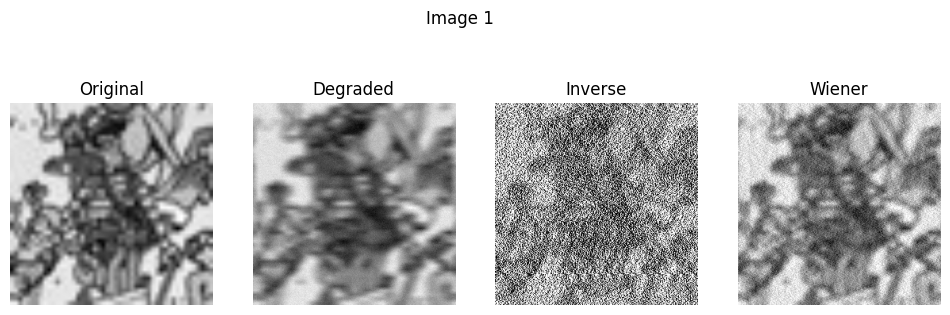

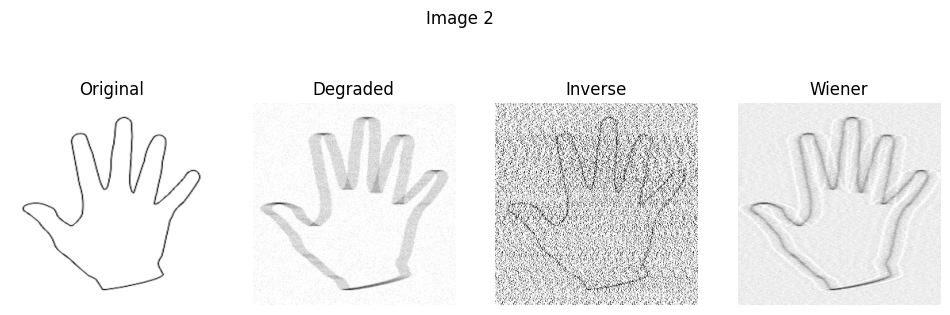

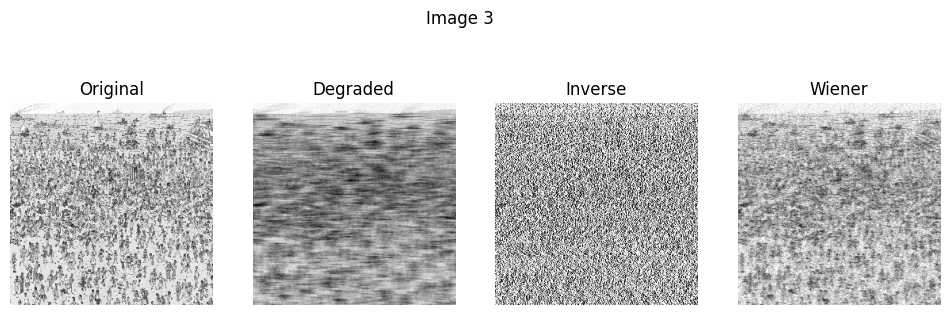

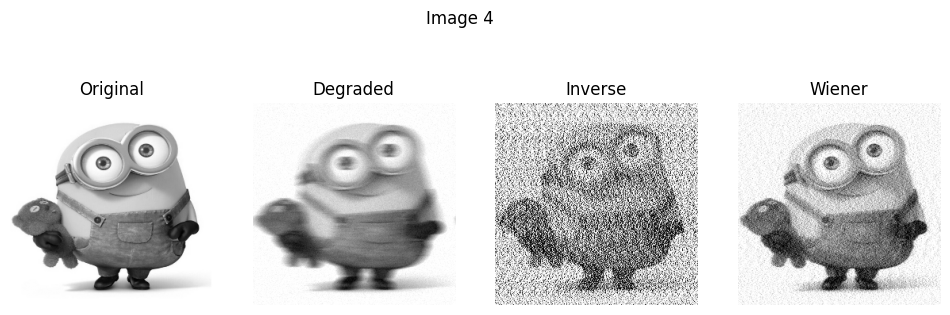

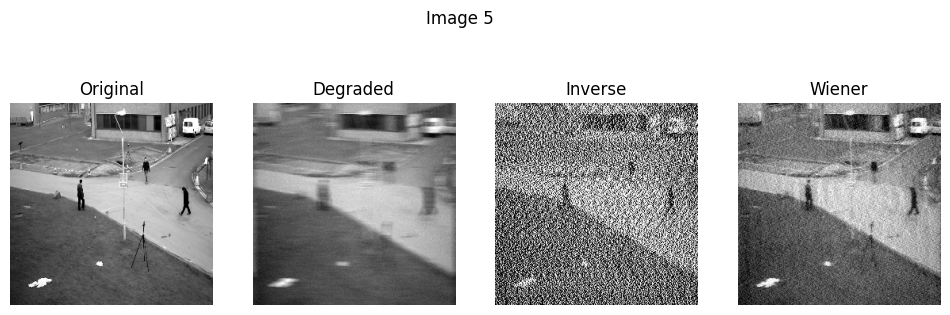

In [7]:
psf = motion_blur_psf(length=15, angle_deg=0, size=256)
noise_sigma = 0.02

for idx, img in enumerate(images):
    degraded, H = degrade_image(img, psf, noise_sigma=noise_sigma)
    G = fft2(degraded)

    signal_var = np.var(img)
    noise_var = noise_sigma**2
    K = noise_var / (signal_var + 1e-12)

    inv_res = inverse_filter(G, H, eps=1e-2)
    wiener_res = wiener_filter(G, H, K)

    # Show results
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(degraded, cmap='gray'); plt.title("Degraded"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(np.clip(inv_res,0,1), cmap='gray'); plt.title("Inverse"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(np.clip(wiener_res,0,1), cmap='gray'); plt.title("Wiener"); plt.axis("off")
    plt.suptitle(f"Image {idx+1}")
    plt.show()